## Finding the Best Classification Model for Intel Image Dataset

In [94]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.utils import shuffle
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import seaborn as sns

from keras.datasets import fashion_mnist
from keras.utils.np_utils import to_categorical   

import cv2
import csv
import os

import warnings
warnings.filterwarnings('ignore')

seed = 1234
np.random.seed(seed) 

### Import Data Images

In [95]:
## Image clean source: https://www.kaggle.com/code/uzairrj/beg-tut-intel-image-classification-93-76-accur

def get_images(path):
    IntelData, Labels = [], []
    
    for labels in os.listdir(path):
        for image_file in os.listdir(path+labels):
            image = cv2.imread(path+labels+r'/'+image_file)
            image = cv2.resize(image,(150,150))
            IntelData.append(image)
            Labels.append(Word_to_Label([labels][0]))
    return shuffle(IntelData,Labels,random_state=seed)
    
def Label_to_Word(label):
    label_dict = {0:"buildings", 1:"forest", 2:"glacier", 3:"mountain", 4:"sea", 5:"street"}
    return label_dict[label]

def Word_to_Label(word):
    word_dict = {"buildings": 0, "forest":1, "glacier":2, "mountain":3, "sea":4, "street":5}
    return word_dict[word]

In [106]:
## read training images

X_tr, y_tr = get_images('./Data/seg_train/seg_train/')
X_tr = np.array(X_tr)
y_tr = np.array(y_tr)

X_te, y_te = get_images('./Data/seg_test/seg_test/')
X_te = np.array(X_te)
y_te = np.array(y_te)


print(X_tr.shape, y_tr.shape)
print(X_te.shape, y_te.shape)


(14034, 150, 150, 3) (14034,)
(3000, 150, 150, 3) (3000,)


### Take a Glimpse at the Data

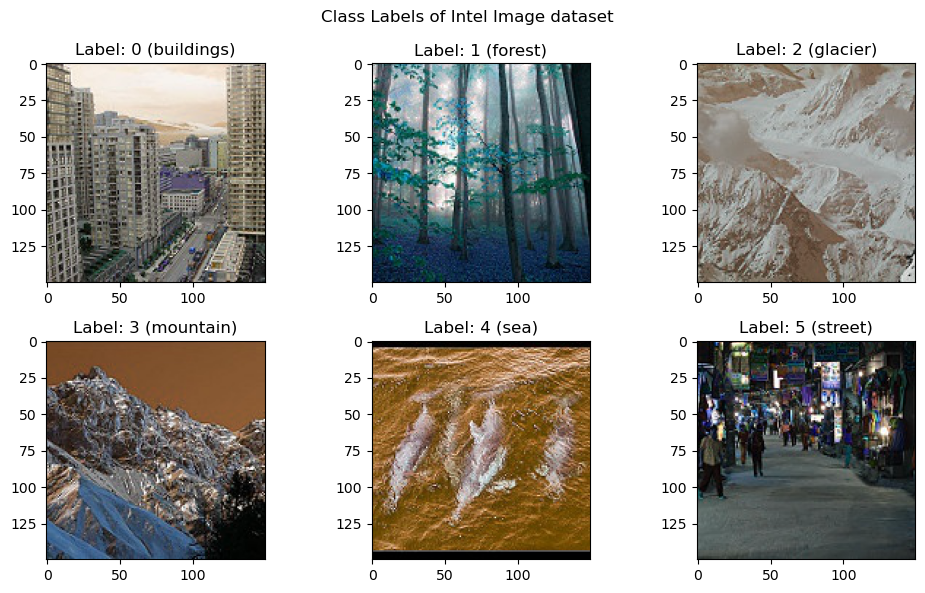

In [107]:
def find(arr, elem):
    for index, item in enumerate(arr):
        if item == elem:
            return index

figure, axes = plt.subplots(2, 3, figsize=(10, 6)) 

TrueLabels = {0:"buildings", 1:"forest", 2:"glacier", 3:"mountain", 4:"sea", 5:"street"}

i = 0
for x in range(2): 
    for y in range(3):
        index = find(y_tr, i)
        axes[x, y].imshow(X_tr[index]) 
        axes[x, y].set_title(f'Label: {i} ({TrueLabels[i]})') 
        i+= 1

plt.suptitle("Class Labels of Intel Image dataset")
plt.tight_layout() 


### Clean and Standardize Data

In [108]:
X_tr = np.reshape(X_tr, (14034,67500))
X_te = np.reshape(X_te, (3000,67500))

y_tr = y_tr.flatten()
y_te = y_te.flatten()

scaler = StandardScaler()
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)
X_val = scaler.transform(X_val)

X_tr, X_val, y_tr, y_val = train_test_split(X_tr, y_tr, test_size=0.20, random_state=seed, shuffle=True)

print(X_tr.shape, y_tr.shape)
print(X_val.shape, y_val.shape)

(11227, 67500) (11227,)
(2807, 67500) (2807,)


### Make Confusion Matrix

In [109]:
def cm(y_pred, title):
    fig, ax = plt.subplots(figsize=(7, 5))

    sklearn_cm_eu = confusion_matrix(y_te, y_pred)
    sns.heatmap(sklearn_cm_eu, annot=True, ax=ax, fmt='g')

    ax.set_ylabel("True Label")
    ax.set_xlabel("Predicted Label")

    ax.set_title(f"Confusion Matrix of Fashion-MNIST using {title}")
    return plt

### Record Results

In [110]:
def write_results(file, settings, headers):   
    with open(file, "a", newline='\n') as f:
        writer = csv.DictWriter(f, fieldnames=headers)
        writer.writerow(settings)

def view_results(file):
    df = pd.read_csv(file)
    return df

### Show Incorrect Predictions

In [120]:
def find_incorrect(predictions, true_label, predict_label):
    
    results = []
    length = len(y_te)
    for i in range(length):
        if y_te[i] == true_label and predictions[i] == predict_label:
            results.append(i)
        if len(results) == 10:
            return results

def print_incorrect(predictions, true_label, predict_label):
    
    indices = find_incorrect(predictions, true_label, predict_label)
    
    plt.rcParams['image.interpolation'] = 'nearest'
    plt.rcParams['image.cmap'] = 'gray' 
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    
    for i in range(10):
        axes[i//5, i%5].imshow(X_te[indices[i]].reshape(150, 150, 3))
        
    fig.suptitle(f"Images of {TrueLabels[true_label]} And Predicted As {TrueLabels[predict_label]}")
    plt.tight_layout()
    return plt

### Nearest Centroid

In [112]:
nc = NearestCentroid().fit(X_tr, y_tr)
train_predict = nc.predict(X_tr)
val_predict = nc.predict(X_val)
test_predict = nc.predict(X_te)

results = {"Train Accuracy": [0], "Validation Accuracy": [0], "Test Accuracy": [0]}

results["Train Accuracy"][0] = accuracy_score(y_tr, train_predict)
results["Validation Accuracy"][0] = accuracy_score(y_val, val_predict)
results["Test Accuracy"][0] = accuracy_score(y_te, test_predict)

df_nc = pd.DataFrame(results)

df_nc

Train Accuracy  Validation Accuracy  Test Accuracy
0        0.443217             0.444959       0.214333

In [114]:
df_nc.to_csv('./results/nc.csv', index=False)

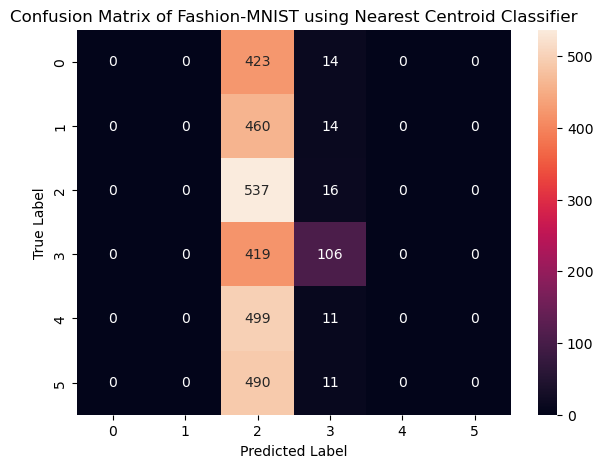

In [115]:
cm_knn = cm(test_predict, "Nearest Centroid Classifier")
cm_knn.show()

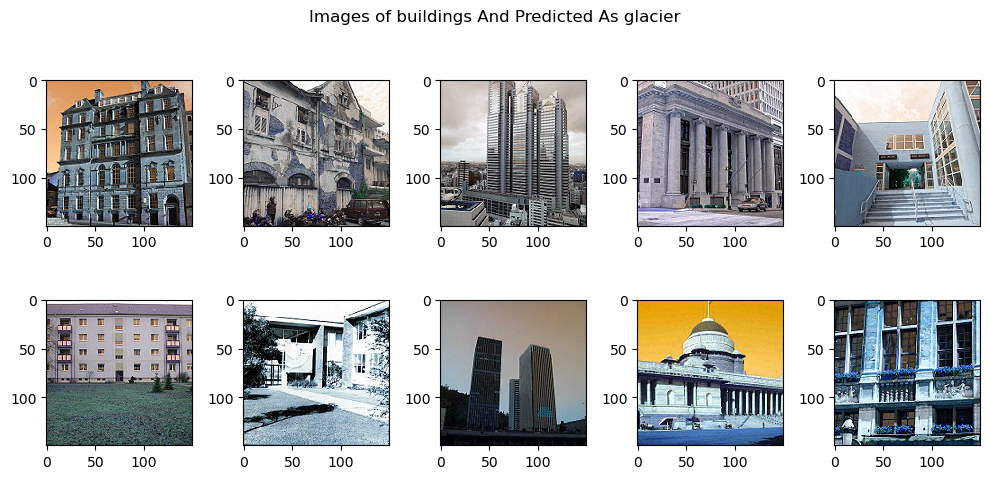

In [121]:
wrong_predictions = print_incorrect(test_predict, 0, 2)
wrong_predictions.show()

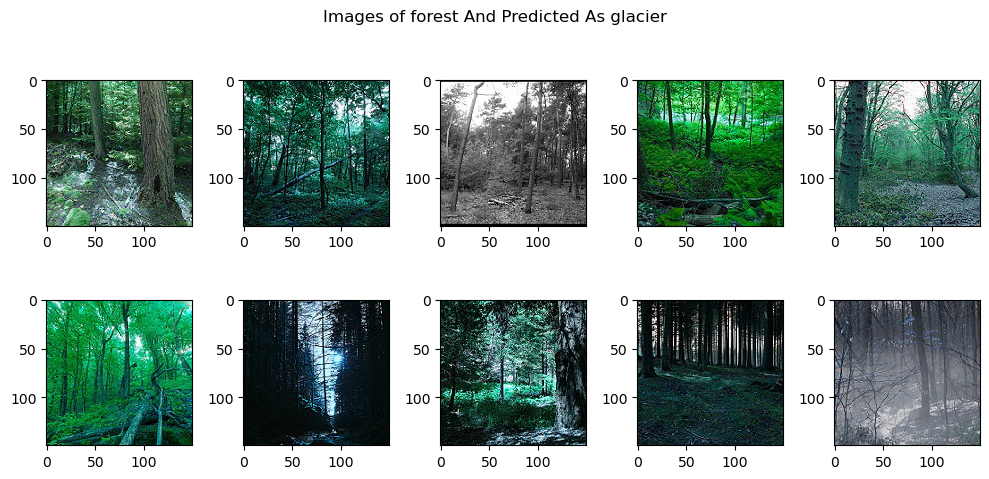

In [122]:
wrong_predictions = print_incorrect(test_predict, 1, 2)
wrong_predictions.show()

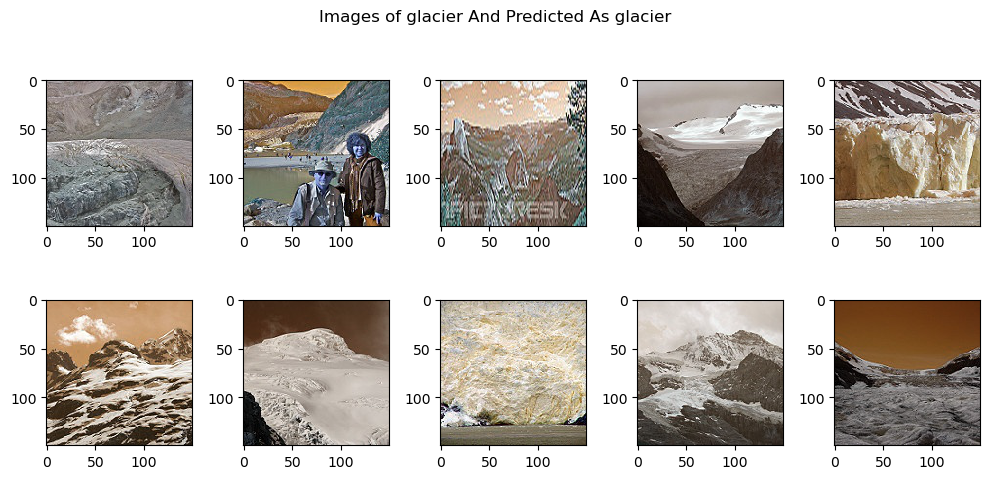

In [123]:
wrong_predictions = print_incorrect(test_predict, 2, 2)
wrong_predictions.show()

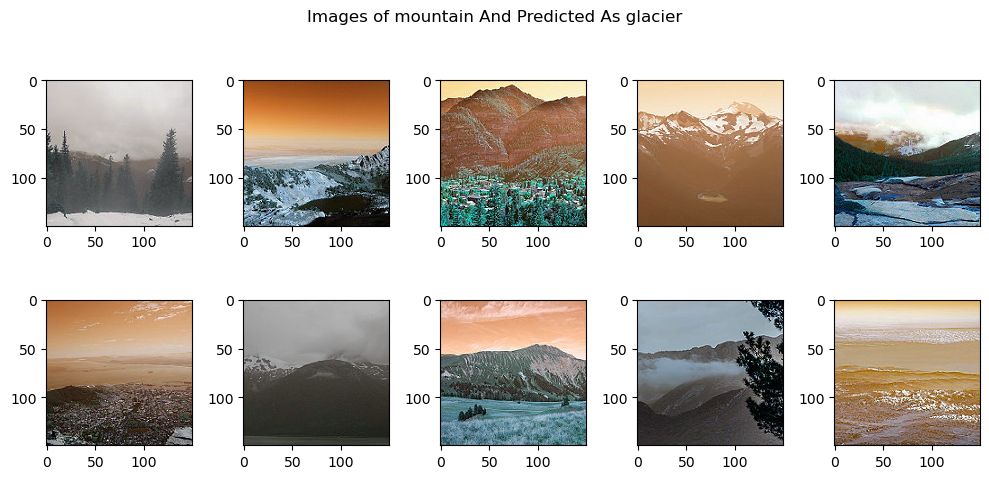

In [124]:
wrong_predictions = print_incorrect(test_predict, 3, 2)
wrong_predictions.show()

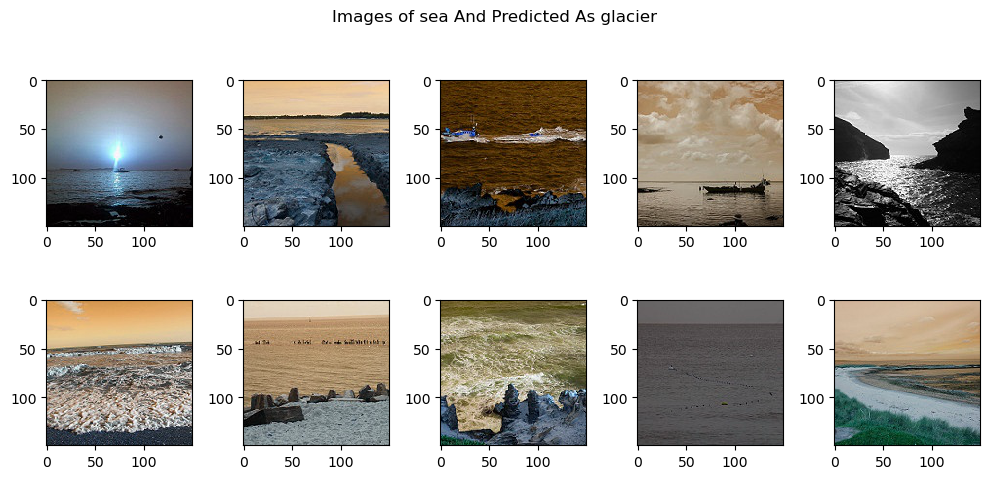

In [125]:
wrong_predictions = print_incorrect(test_predict, 4, 2)
wrong_predictions.show()

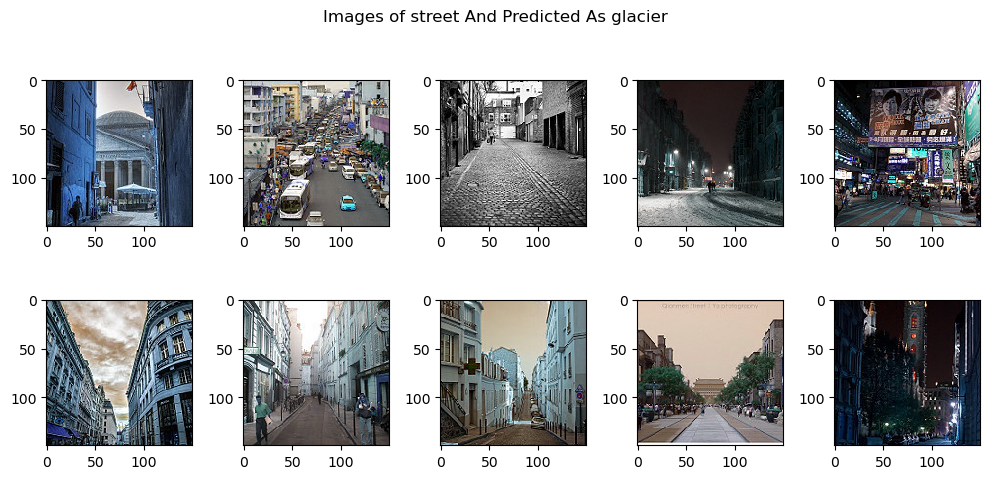

In [126]:
wrong_predictions = print_incorrect(test_predict, 5, 2)
wrong_predictions.show()